In [135]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model


# DataFrame

In [136]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [137]:
target= ['cnt']
y= df['cnt']

# Limpieza de Datos

In [138]:
df= df.drop(columns=['casual', 'registered', 'instant', 'dteday', 'mnth', 'yr'])
df.head()

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


# Modelo sin Scaler

In [139]:
X = df.copy().drop(target, axis=1)
X = pd.get_dummies(X, columns=["season", "weekday", "weathersit"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsRegressor(n_neighbors=4).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)

print('R^2:  ', r2_score(y_true=y_test, y_pred=predicciones))


R^2:   0.42695563870012765


# Función

In [140]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

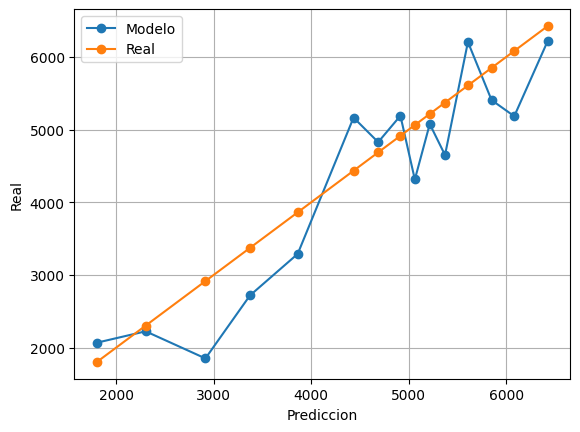

In [141]:
calibracion(predicciones, y_test, 15)

# Scaler

In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con Scaler

R2: 0.43254838674846496


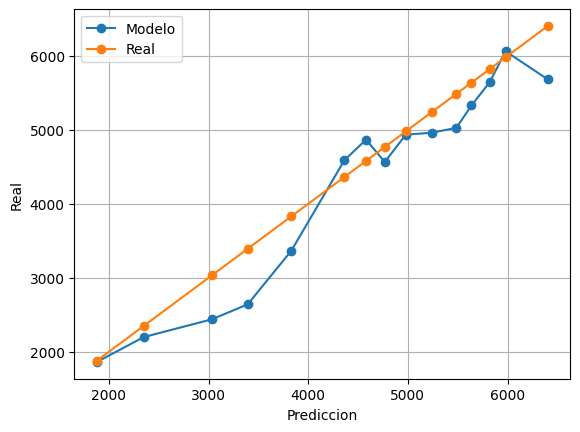

In [143]:
model = KNeighborsRegressor().fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
r2 = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R2: {r2}")
calibracion(predicciones, y_test, 15)

# KNN

In [152]:
nn = []
r2 = []
r2_train = []
for i in range(1, 60):
    model = KNeighborsRegressor(n_neighbors=i).fit(X_train_scaled, y_train)
    predicciones = model.predict(X_test_scaled)
    r2.append(r2_score(y_true=y_test, y_pred=predicciones))
    nn.append(i)
    predicciones_train = model.predict(X_train_scaled)
    r2_train.append(r2_score(y_true=y_train, y_pred=predicciones_train))

resultados = pd.DataFrame({'r2': r2, 'nn': nn, 'r2_train': r2_train})

nn_opt = resultados[resultados.r2 == max(resultados.r2)].nn.values[0]


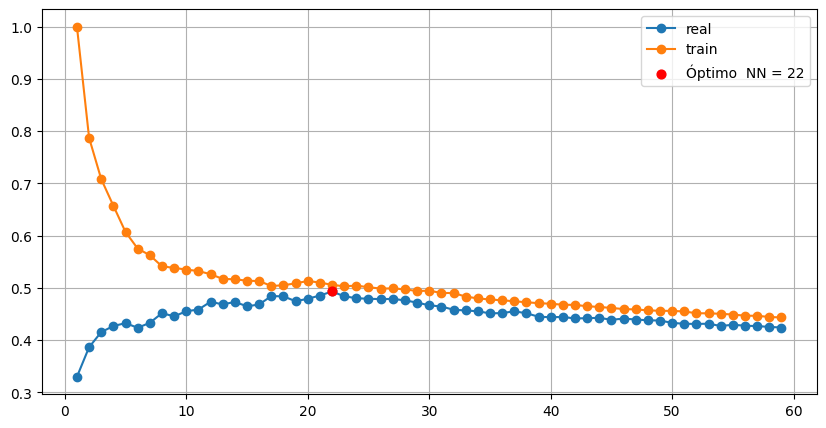

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(resultados.nn, resultados.r2, label='real', marker='o')
plt.plot(resultados.nn, resultados.r2_train, label='train', marker='o')
plt.scatter(nn_opt, max(resultados.r2), label=f'Óptimo  NN = {nn_opt}', color= 'red', s=40, zorder=30)
plt.grid()
plt.legend()

R^2 con 22 neighbors: 0.4931


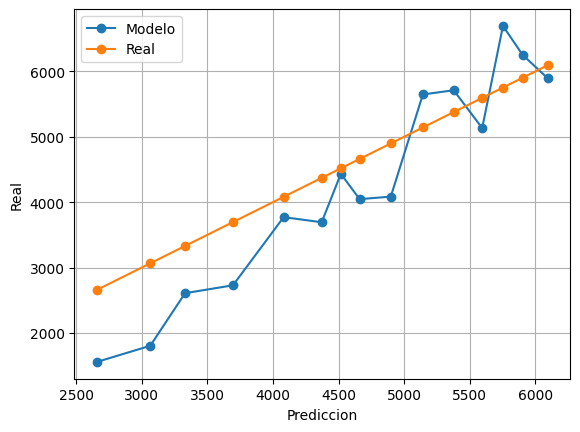

In [154]:
model = KNeighborsRegressor(n_neighbors=nn_opt).fit(X_train_scaled, y_train)
predicciones = model.predict(X_test_scaled)
nn_opt_nbr = r2_score(y_true=y_test, y_pred=predicciones)

print(f"R^2 con {nn_opt} neighbors: {nn_opt_nbr:.4f}")
calibracion(predicciones, y_test, 15)

# Conclusión

El número óptimo de vecinos en el modelo KNN es 22 , con un $ R^2 $ de 0.4931. Si este valor aumenta o disminuye, el coeficiente de determinación $ R^2 $ puede verse afectado negativamente, lo que indica un ajuste menos preciso del modelo. Un número menor de vecinos podría hacer que el modelo sea demasiado sensible al overfitting, mientras que un número mayor podría suavizar demasiado las predicciones y reducir su precisión. Con esto vimos que aplicando scaler es mejor que si no lo aplicásemos. 